In [25]:
import matplotlib.pyplot as plt
import netCDF4
import os, glob
import numpy as np
from scipy.interpolate import griddata
import h5py

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

EPS = 1e-4 #np.finfo(float).eps

In [26]:
CMROOT = r"C:\Users\axt5780\OneDrive - The Pennsylvania State University\PIML_project\IMERG_vectors"
CMROOT = '/glade/work/jpan/IMERG_vecs/'
nc_files = glob.glob(os.path.join(CMROOT, "*.nc"))

all_data = []
for nc_file in nc_files:
    channel_vec = netCDF4.Dataset(nc_file)
    data = channel_vec['pmmhr'][:, :]
    
    if np.isnan(data).any():
        valid_mask = ~np.isnan(data)
        nan_mask = np.isnan(data)  
        
        x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
      
        interpolated_data = griddata(
              points=(x[valid_mask], y[valid_mask]),
              values=data[valid_mask],
              xi=(x[nan_mask], y[nan_mask]),
              method='linear'
        )
        
        data[nan_mask] = interpolated_data
        
    all_data.append(data)
    channel_vec.close()
    
train = np.concatenate(all_data, axis=0)

print("Combined data shape:", train.shape)

Combined data shape: (13104, 39125)


In [7]:
log_tr = np.log(train + EPS)
tr_log_norm = (log_tr - np.min(log_tr)) / (np.max(log_tr) - np.min(log_tr))

In [9]:
tr_log_norm

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.5467311567947836, 0.7185829752451997, ..., 0.0, 0.0, 0.0],
        [0.0, 0.5694339167525353, 0.5071817539194161, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [38]:
class Autoencoder(Model):
  '''def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='sigmoid'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])'''

  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(), # 64k
      layers.Dense(latent_dim*8, activation='swish'), # 64k -> latent_dim*8
      layers.Dense(latent_dim, activation='swish'), # latent_dim*8 -> laten_dim
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(latent_dim*8, activation='swish'), # latent_dim -> latent_dim*8
      layers.Dense(tf.math.reduce_prod(shape).numpy()), # latent_dim*8 -> vector w/o activation
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [39]:
shape = train.shape[1:]
latent_dim = 64

In [40]:
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(tr_log_norm, tr_log_norm,
              epochs=50,
          shuffle=True)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 283s 676ms/step - loss: 0.0206
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 228s 448ms/step - loss: 0.0168
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 186s 410ms/step - loss: 0.0155
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 204s 415ms/step - loss: 0.0147
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 199s 409ms/step - loss: 0.0141
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 204s 415ms/step - loss: 0.0137
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 202s 415ms/step - loss: 0.0136
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 199s 409ms/step - loss: 0.0135
Epoch 9/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 204s 415ms/step - loss: 0.0131
Epoch 10/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 216s 448ms/step - loss: 0.0131
Epoch 11/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 188s 414ms/step - loss: 0.0130
Epoch 12/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 412ms/step - loss: 0.0129
Epoch 13/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 203s 414ms/step - loss: 0.0129
Epoch 14/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 202s 414ms/step - loss: 0.0128
E

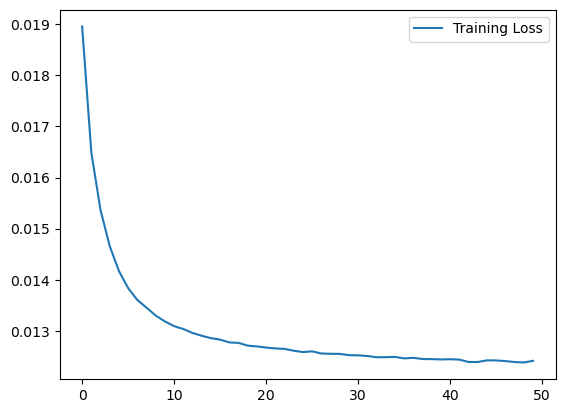

In [41]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [42]:
autoencoder.save_weights(f'weights/IMERG_{latent_dim}_downsample_log.weights.h5')
print("Weights saved successfully.")

Weights saved successfully.


## REOPENING THE MODEL WITH WEIGHTS

In [43]:
ae1 = Autoencoder(latent_dim, shape) 
ae1.predict(tr_log_norm)
ae1.load_weights(f'weights/IMERG_{latent_dim}_downsample_log.weights.h5')

410/410 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step


In [44]:
[ae1.weights[ii] - autoencoder.weights[ii] for ii in range(len(ae1.weights))]

[<tf.Tensor: shape=(39125, 512), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(512,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

#### Loaded weights of the new model match the weights of the original model

# Check whether the distribution of encoded data matches original data

In [45]:
pred[:, ::100].ravel()

array([6.31043330e-05, 5.78578644e-05, 5.08281445e-05, ...,
       2.52477178e-04, 3.91260313e-04, 2.36951327e-04])

In [46]:
ae1.summary()

Model: "autoencoder_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (32, 64)               │    20,065,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (32, 39125)            │    20,104,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,169,749 (153.24 MB)

 Trainable params: 40,169,749 (153.24 MB)

 Non-trainable params: 0 (0.00 B)

Text(0.5, 0, 'p rate [mm/h]')

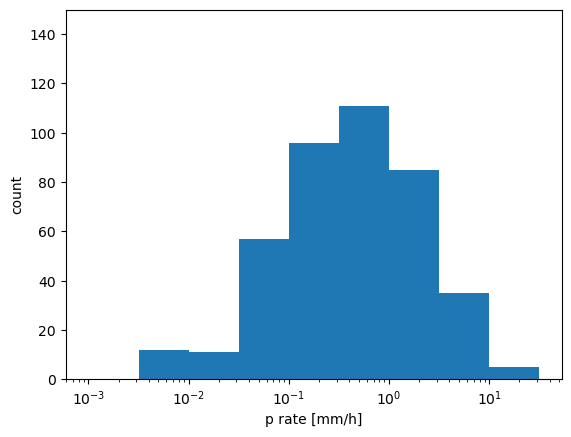

In [57]:
plt.hist(train[::1000, ::100].ravel(), bins=10**np.arange(-3, 2, 0.5))
plt.xscale('log')
plt.ylim(0, 150)
plt.ylabel('count')
plt.xlabel('p rate [mm/h]')

In [48]:
pred_log_norm = ae1.predict(tr_log_norm[::1000])
log_pred = pred_log_norm * (np.max(log_tr) - np.min(log_tr)) + np.min(log_tr)
pred = np.exp(log_pred) - EPS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Text(0.5, 0, 'p rate [mm/h]')

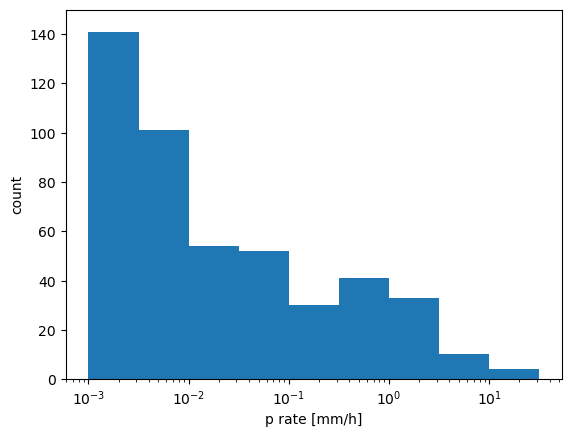

In [58]:
plt.hist(pred[:, ::100].ravel(), bins=10**np.arange(-3, 2, 0.5))
plt.xscale('log')
plt.ylim(0, 150)
plt.ylabel('count')
plt.xlabel('p rate [mm/h]')

In [54]:
(pred[:, ::100] < EPS).sum()

np.int64(4177)

In [56]:
(train[::1000, ::100] < EPS).sum()

np.int64(5075)